In [225]:
import pandas as pd
import numpy as np
import scipy as sc

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing, linear_model
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [2]:
original_data = pd.read_csv("Houses_data.csv")

**Data description:**

In [4]:
original_data.head()

,id,Price,Size,Lot,Bath,Bed,Year,Age,Garage,Status,elem
0,1,388.0,2.180,4,3.0,4,1940,-3.0,0,sld,edison
1,2,450.0,2.054,5,3.0,4,1957,-1.3,2,sld,edison
2,3,386.0,2.112,5,2.0,4,1955,-1.5,2,sld,edison
3,4,350.0,1.442,6,1.0,2,1956,-1.4,1,act,adams
4,5,155.5,1.800,1,2.0,4,1994,2.4,1,sld,adams


In [5]:
original_data.describe()

,id,Price,Size,Lot,Bath,Bed,Year,Age,Garage
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,38.500000,285.795395,26.787658,3.986842,2.207895,3.447368,1969.539474,-0.059211,1.565789
std,22.083176,60.332686,216.342411,1.653227,0.570325,0.737468,23.721406,2.349251,0.771760
min,1.000000,155.500000,1.440000,1.000000,1.000000,2.000000,1905.000000,-6.500000,0.000000
25%,19.750000,242.750000,1.860750,3.000000,2.000000,3.000000,1957.750000,-1.225000,1.000000
50%,38.500000,276.000000,1.971000,4.000000,2.000000,3.000000,1969.500000,-0.050000,2.000000
75%,57.250000,336.750000,2.112000,5.000000,3.000000,4.000000,1980.000000,1.000000,2.000000
max,76.000000,450.000000,1888.000000,11.000000,3.100000,6.000000,2015.000000,3.500000,3.000000


**The main problem here is a lack of data - only 76 observations **

In [10]:
data = original_data.copy()

**Let's look closer at Size column. We see that size quantiles are pretty small compared to max value. Let's check this out**

In [11]:
data.iloc[data.Size.idxmax()]

id            35
Price      252.5
Size        1888
Lot            2
Bath           2
Bed            6
Year        1920
Age           -5
Garage         0
Status       sld
elem      edison
Name: 34, dtype: object

** That must be a mistake. Usually we drop it but as we have only 76 observation we'll change it to 1.888 (I hope that is the correct one) **

In [14]:
data = data.set_value(34, 'Size', 1.888)

** Now  let's check categorial features. These are nearest school name and sales status. We create dummy columns for them using one-hot encoding. I don't know the bussiness meaning of 'Status' and I guess it is a posteriori information that doesn't affect house pricing but on other hand saled / not saled may contain information about the accordance of price so I keep it.**

In [15]:
status_dummies = pd.get_dummies(data["Status"])
status_dummies.columns = status_dummies.columns.map(lambda x: "status_" + x)

data.drop("Status", axis=1, inplace=True)
data = data.join(status_dummies)

In [16]:
elem_dummies = pd.get_dummies(data["elem"])
elem_dummies.columns = elem_dummies.columns.map(lambda x: "elem_" + x)

data.drop("elem", axis=1, inplace=True)
data = data.join(elem_dummies)

In [17]:
data.head()

,id,Price,Size,Lot,Bath,Bed,Year,Age,Garage,status_act,status_pen,status_sld,elem_adams,elem_crest,elem_edge,elem_edison,elem_harris,elem_parker
0,1,388.0,2.180,4,3.0,4,1940,-3.0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,450.0,2.054,5,3.0,4,1957,-1.3,2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,386.0,2.112,5,2.0,4,1955,-1.5,2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,350.0,1.442,6,1.0,2,1956,-1.4,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,155.5,1.800,1,2.0,4,1994,2.4,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


** As we know from description, Age column is standardized Year so to avoid data duplication we drop Year column. Also we drop Id. **

In [18]:
data.drop("id", axis=1, inplace=True)
data.drop("Year", axis=1, inplace=True)

** Let's see how Price depends on each single feature. Also we draw linear regressions with 95% conf interval using seaborn lib. **

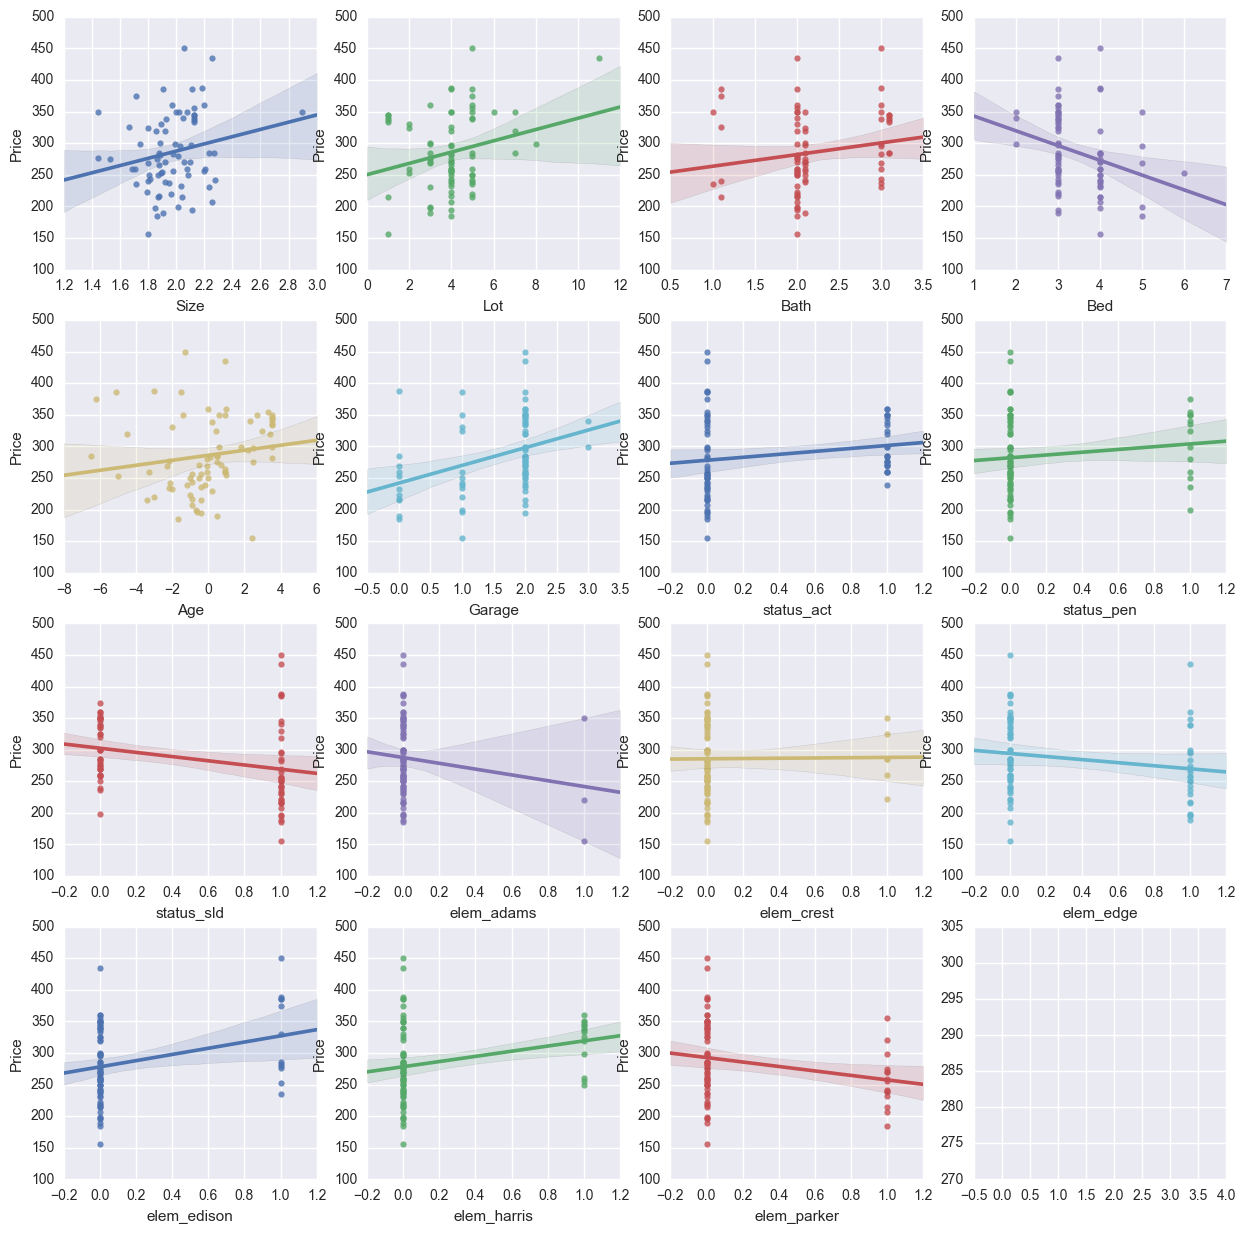

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for idx, feature in enumerate(data.columns[1:17]):
    #data.plot(feature, "Price", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])
    seaborn.regplot(x = feature,
           y = "Price", 
           data = data, ax=axes[idx / 4, idx % 4])

** We see that price decreases with number of badrooms. That doesn't make any sense for me so I add new feature - size per badroom: **

In [161]:
data.loc[:,'size_per_bed'] = pd.Series(data.Size / data.Bed, index=data.index)

** Correlation map: **

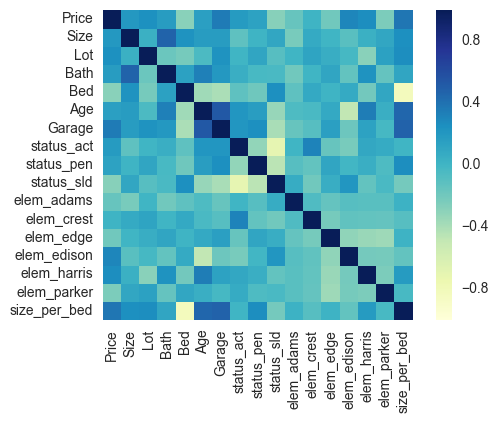

In [162]:
seaborn.heatmap(data.corr(), square=True, cmap="YlGnBu")

** We also if there is no target column skewness: **

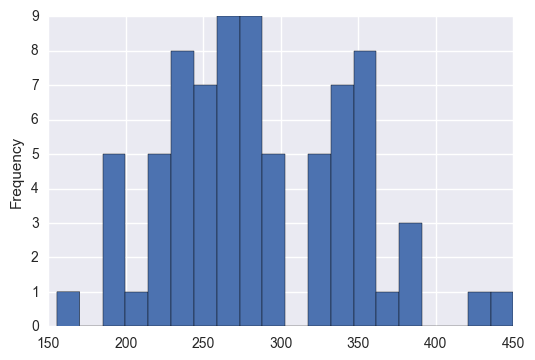

In [28]:
data['Price'].plot.hist(bins=20)

**Looks okay. Next we create features/labels datasets. As I mentioned above - the main problem is lack of data and there is no sense to split into train/test sets. Instead we perform cross validation with mean squared error score. **

In [337]:
X = data.iloc[:, 1:18]
y = data.iloc[:, 0]

In [338]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [339]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X, y, scoring = scorer, cv = 6)).mean()

def plot_regression(model, cols = data.columns[1:18]):
    model.fit(X, y)
    y_pred = model.predict(X)

    plt.figure(figsize=(16,5))

    plt.subplot(131)
    plt.scatter(y_pred, y_pred - y, c = "blue")
    plt.title("Residuals")
    plt.hlines(y = 0, xmin = 150, xmax = 400, color = "red")

    plt.subplot(132)
    plt.scatter(y_pred, y, c = "blue")
    plt.title("Model")
    plt.plot([150, 400], [150, 400], c = "red")

    plt.subplot(133)
    coefs = pd.Series(model.coef_, index = cols)
    coefs.sort_values().plot(kind = "barh")
    plt.title("Coefficients in the Model")
    plt.show()

** Linear regression is a usual approach for this kind of tasks. (There are also another models for example ensembling methods but with this small dataset we'll always overfit) **

In [340]:
lr = linear_model.LinearRegression()
print rmse_cv(lr)

51.8617311788


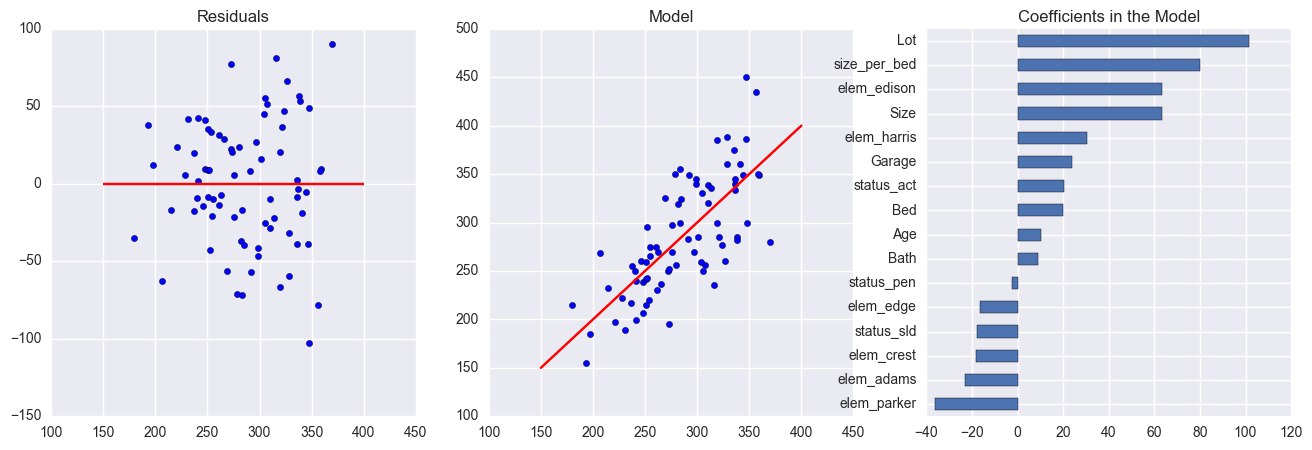

In [341]:
plot_regression(lr)

** Some of the coefs are really small comparing to others. The idea is to shrink them using regularization technique. L1 regularization yields sparse feature vectors: some feature weights will be zero **

50.7301254312


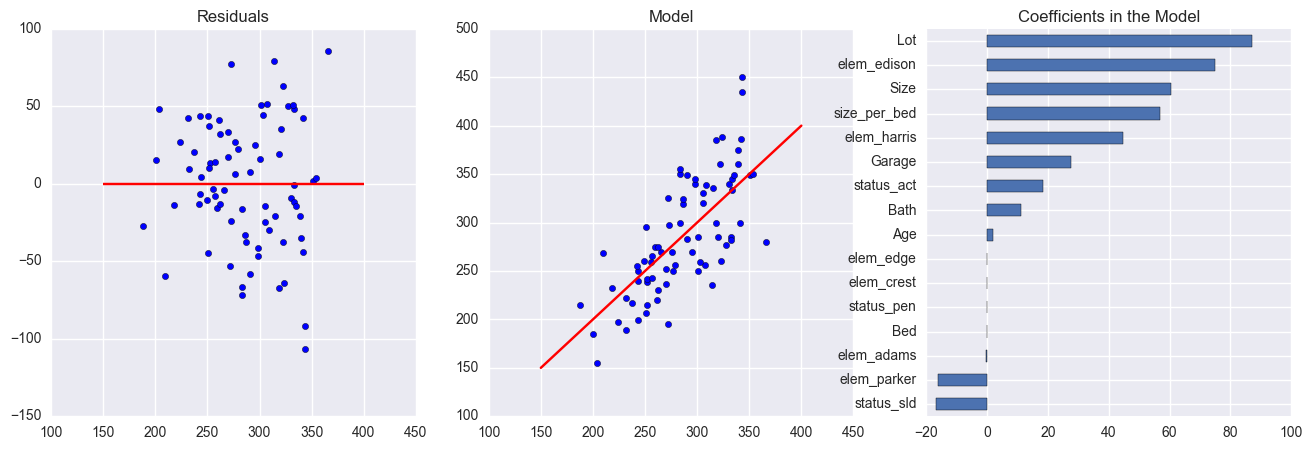

In [327]:
lasso = linear_model.LassoCV(alphas=[0.3])
print rmse_cv(lasso)

plot_regression(lasso)

** Nice. We see that 3 school features and number of bedrooms were sparsed. We can interpret it as Edison elementary in your neighborhood efficiently increase house price (has high positive coeficient), as also Parker's slightly decrease. **

** And we see that among others model also shrinked a 'Bed' feature as we assumed above. Now let's do some regression analysis using stat models library. First, we add all features to the model**

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     290.6
Date:                Sun, 09 Apr 2017   Prob (F-statistic):           2.76e-51
Time:                        08:21:28   Log-Likelihood:                -389.06
No. Observations:                  76   AIC:                             808.1
Df Residuals:                      61   BIC:                             843.1
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       37.1265     54.313      0.684   

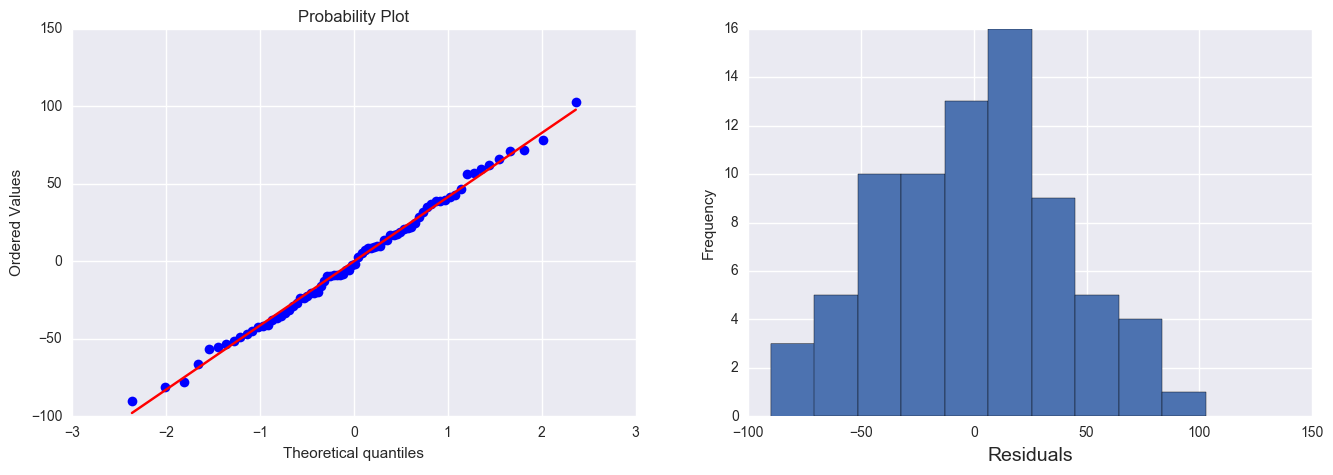

In [246]:
model = smf.ols('Price ~ Size + Lot + Bath + Bed + Age + Garage + size_per_bed +'\
                    'status_act + status_pen + status_sld + elem_adams +'\
                    'elem_crest + elem_edge + elem_edison + elem_harris + elem_parker', 
             data = data)
fitted = model.fit(cov_type='HC1')
print fitted.summary()

plt.figure(figsize = (16,5))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=plt)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.show()

** Look at "P>|z|". Values over 0.5 are not statistically significant (with 0.95 prob). These are the same three elementary school, status actual/pending and bed, age, bath features. All these columns have small coeficients in our Lasso model above. Building model without them:**

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     13.52
Date:                Sun, 09 Apr 2017   Prob (F-statistic):           1.93e-11
Time:                        09:25:14   Log-Likelihood:                -389.97
No. Observations:                  76   AIC:                             797.9
Df Residuals:                      67   BIC:                             818.9
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       36.4080     48.065      0.757   

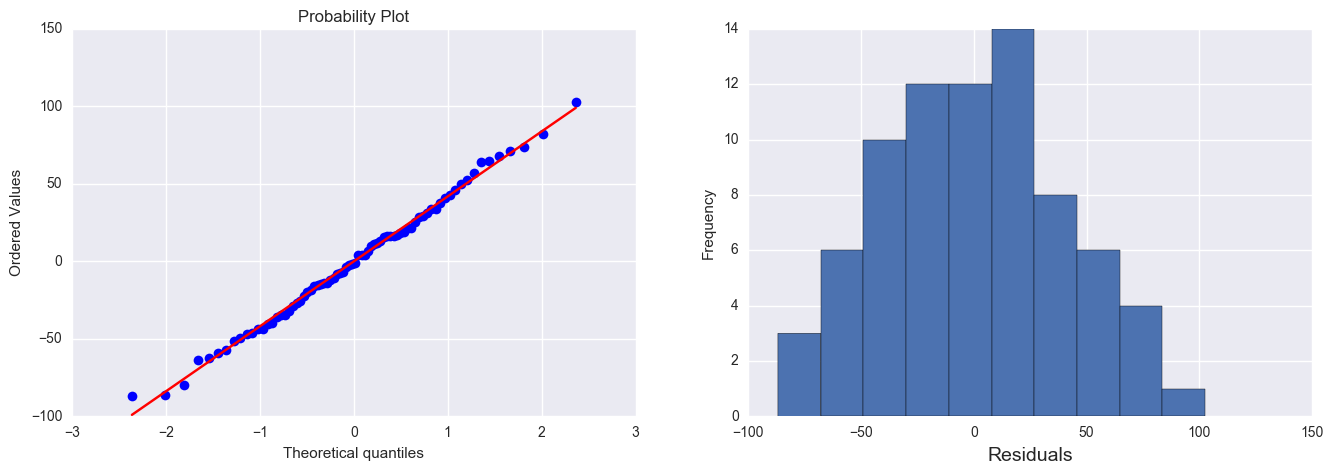

In [294]:
model2 = smf.ols('Price ~ Size + Lot + Garage + size_per_bed +'\
                    'status_act +'\
                    'elem_edison + elem_harris + elem_parker', 
             data = data)
fitted2 = model2.fit(cov_type='HC1')
print fitted2.summary()

plt.figure(figsize = (16,5))
plt.subplot(121)
sc.stats.probplot(fitted2.resid, dist="norm", plot=plt)
plt.subplot(122)
fitted2.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.show()

** R-squared (Coefficient of determination) fell down slightly. Let's use Fisher criteria to check if the shrinked model is still good enough: (yes it is) ** 

In [296]:
print "F=%f, p=%f, k1=%f" % model.fit().compare_f_test(model2.fit())

F=0.247851, p=0.958369, k1=6.000000


** Let's see how residuals distributed over top-5 features. The model shows heteroscedasticity robust warning but we've already made White correction. **

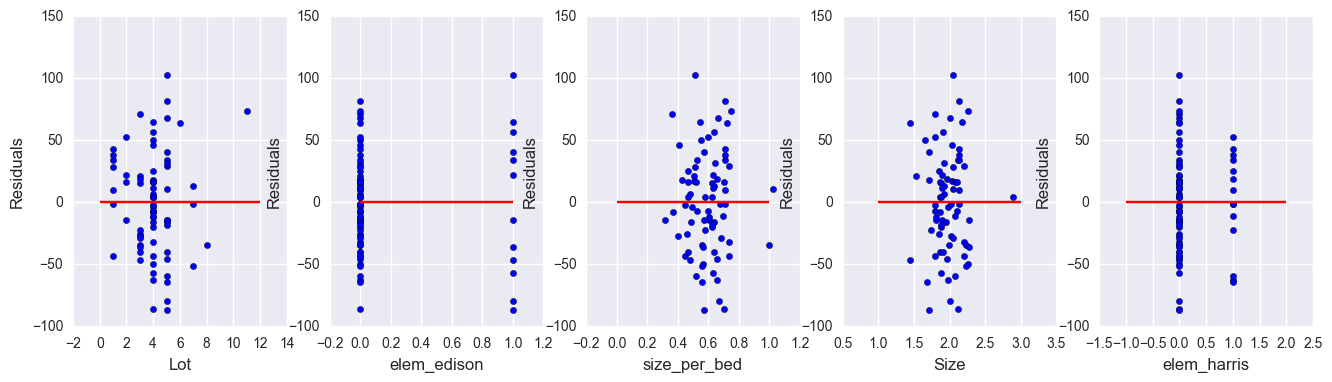

In [306]:
plt.figure(figsize=(16, 4))
plt.subplot(151)
plt.scatter(data['Lot'], fitted2.resid)
plt.xlabel('Lot', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.hlines(y = 0, xmin = 0, xmax = 12, color = "red")

plt.subplot(152)
plt.scatter(data['elem_edison'], fitted2.resid)
plt.xlabel('elem_edison', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.hlines(y = 0, xmin = 0, xmax = 1, color = "red")
    
plt.subplot(153)
plt.scatter(data['size_per_bed'], fitted2.resid)
plt.xlabel('size_per_bed', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.hlines(y = 0, xmin = 0, xmax = 1, color = "red")

plt.subplot(154)
plt.scatter(data['Size'], fitted2.resid)
plt.xlabel('Size', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.hlines(y = 0, xmin = 1, xmax = 3, color = "red")

plt.subplot(155)
plt.scatter(data['elem_harris'], fitted2.resid)
plt.xlabel('elem_harris', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.hlines(y = 0, xmin = -1, xmax = 2, color = "red")
plt.show()

** Nothing special except maybe one point in Lot column: **

In [308]:
data.iloc[data.Lot.idxmax()]

Price           435.000
Size              2.253
Lot              11.000
Bath              2.000
Bed               3.000
Age               0.900
Garage            2.000
status_act        0.000
status_pen        0.000
status_sld        1.000
elem_adams        0.000
elem_crest        0.000
elem_edge         1.000
elem_edison       0.000
elem_harris       0.000
elem_parker       0.000
size_per_bed      0.751
Name: 73, dtype: float64

** That's the only value in 9-11 range. Finally let's take a look how some points affect regression model. (Interesting, our point n73 isn't in high-leverage or high-residuals group) **

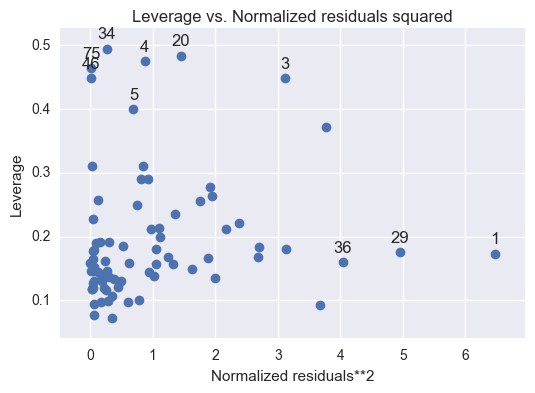

In [290]:
plt.figure(figsize=(2,2))
plot_leverage_resid2(fitted)
plt.show()

** We won't drop them today :) So our current model explains more than 50% of varriance (R2 value) and that's a good result. Final model - Linear Regression with only 7 significant features: Size, Lot, Garage, Size Per Bedroom, Status: Active, and 3 schools: Edison's, Harris', Parker's**

48.0071653353


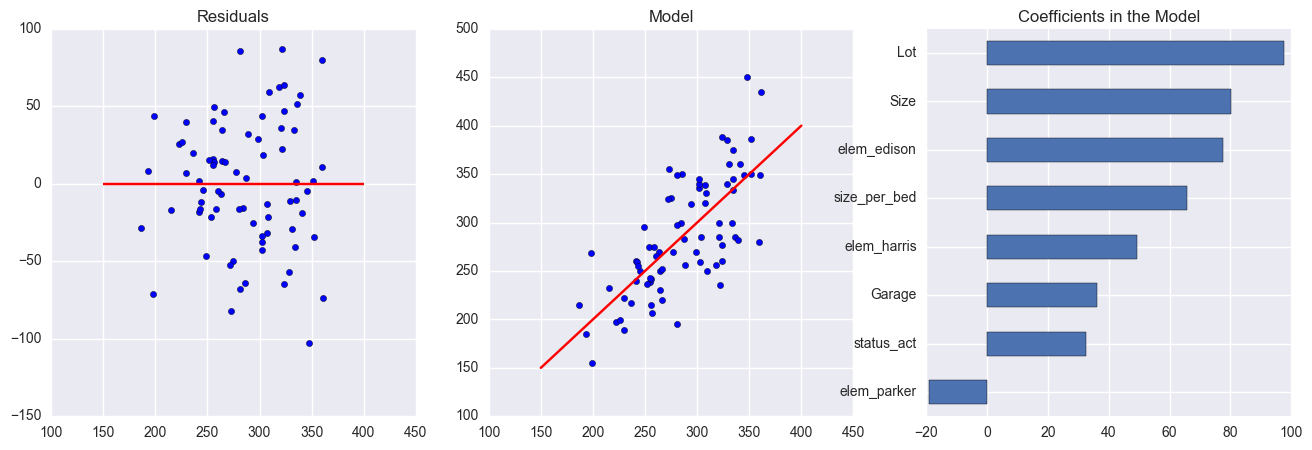

In [347]:
selected_cols = ["Size", "Lot", "Garage", "size_per_bed", "status_act", "elem_edison", "elem_harris", "elem_parker"]
X = data[selected_cols]
y = data.iloc[:, 0]

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

lasso = linear_model.LinearRegression()
print rmse_cv(lasso)

plot_regression(lasso, cols=selected_cols)